In [5]:
import os
os.chdir("..\\..\\")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import networkx as nx
import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt

In [191]:
# Start with 1% of population infected
def initial_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    
    for node in G.nodes():
        if node in infected: 
            G.nodes[node].update({'status' : 'infected',
                                  'infection_day': 0, 
                                  'contacts_infected': 0})
        else:
            G.nodes[node].update({'status': 'susceptible', 
                                  'infection_day' : -1, 
                                  'contacts_infected': 0})
        
def spread_one_step(G, chance_to_infect = 0.3):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    """
    newly_infected = []
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            for contact in adjacencies[1].keys():
                if G.nodes[contact]['status'] == 'susceptible' and np.random.random() < chance_to_infect:
                        newly_infected.append(contact)
     
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected'})
        
    return len(newly_infected)

# The time for a single person to recover is estimated to be 12 days
#The effective infection time window is estimated to bem around the 4 and the 6th day 
# Infection time window still not implemented
def spread_one_step_with_recover(G, day, infectious_window = [4,6], recover_time = 12, chance_to_infect = 0.5):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day, infectious_window is at which days since infected the person in contagious
    and recovery time is the time between someone getting infected to recovered

    """
    
    newly_infected = []
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            if day - G.nodes[node]['infection_day'] >= recover_time: 
                G.nodes[node]['status'] = 'recovered'
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'susceptible' and np.random.random() < chance_to_infect:
                            newly_infected.append(contact)
                            G.nodes[node]['contacts_infected'] += 1
     
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected', 'infection_day': day})
        
    return len(newly_infected)


def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and recovered
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def simulate_pandemic(G):
    """
    Runs the course of the pandemic from the start until
    90% of the population is simultaneously infected or no one is infected
    """

    pop = len(G.nodes)
    i = current_status(G)['infected'] / pop
    s = (pop - i) / pop
    newly_infected = pop * .05
    r = 0

    status = current_status(G)
    data = [[s,i, r, newly_infected]]
    day = 0
    while status['infected'] < 0.9*pop and status['recovered'] + status['susceptible'] < pop:
        day +=1
        newly_infected = spread_one_step_with_recover(G, day)
        status = current_status(G)
        i = status['infected'] / pop
        s = status['susceptible'] / pop
        r = status['recovered'] / pop
        data.append([s, i, r, newly_infected])

    time_series = pd.DataFrame(data, columns = ['susceptible', 'infected', 'recovered', 'newly_infected'])
    
    return time_series

In [192]:
G = nx.relaxed_caveman_graph(25, 4, 0.25, seed=42)
initial_infection(G, .05)
plot_infection(G)

In [193]:
G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
initial_infection(G, .05)

time_series = simulate_pandemic(G)

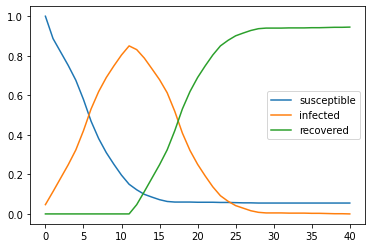

In [194]:
plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['recovered'], label = 'recovered')
plt.legend()
plt.show()

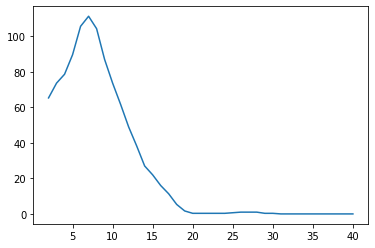

In [195]:
ni_rolling = time_series['newly_infected'].rolling(3).mean()[2:]
plt.plot(ni_rolling.index, ni_rolling.values)


# Disease evolution Model

## source : https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

